In [ ]:
!pip install seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/10718_Fall21/good_feature

/content/drive/MyDrive/10718_Fall21/good_feature


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
from pandas.plotting import table
import scipy
from scipy.stats import pearsonr, spearmanr
from wordcloud import WordCloud, STOPWORDS
import datetime as dt
import plotly
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
# Load data
master = pd.read_csv('processed_mastersheet1025.zip')

In [ ]:
master.shape

(619326, 30)

In [ ]:
master.head(20)

,Unnamed: 0,projectid,teacher_acctid,schoolid,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,students_reached,date_posted,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,total_donation_amount,avg_msg_num_words,fully_funded,day_of_week_posted,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,IL,suburban,f,Mrs.,f,Special Needs,Other,moderate poverty,Grades 3-5,444.36,7.0,2013-12-31,8.0,33.0,10.0,220.0,1.0,0.0,42.50,30.000000,t,1,0.095643,401.86,0.500000,0.0000
1,1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,ID,urban,f,Mrs.,f,Mathematics,Supplies,high poverty,Grades 3-5,233.24,30.0,2013-12-31,3.0,33.0,14.0,175.0,0.0,0.0,0.00,0.000000,f,1,0.000000,233.24,0.500000,0.5000
2,2,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,NH,suburban,f,Mrs.,f,Environmental Science,Technology,moderate poverty,Grades 6-8,285.09,230.0,2013-12-31,3.0,35.0,29.0,390.0,0.0,0.0,0.00,0.000000,f,1,0.000000,285.09,0.500000,0.5000
3,3,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,VA,urban,f,Ms.,f,Literacy,Other,highest poverty,Grades PreK-2,232.94,18.0,2013-12-31,3.0,34.0,18.0,187.0,1.0,0.0,42.50,0.000000,f,1,0.182450,190.44,0.541667,0.6000
4,4,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,IL,urban,f,Mr.,f,Environmental Science,Supplies,highest poverty,Grades 6-8,513.41,70.0,2013-12-31,3.0,35.0,30.0,347.0,0.0,0.0,0.00,0.000000,t,1,0.000000,513.41,0.000000,0.0000
5,5,c685c844476d7ed75bf87699eeafd682,4b19500fb087a635c98061505f1e6c6f,34c650f9f6d5c3e42b8e2169c280ecb7,SC,urban,f,Mrs.,f,Literature & Writing,Supplies,high poverty,Grades PreK-2,688.11,22.0,2013-12-31,6.0,32.0,15.0,187.0,2.0,0.0,42.50,24.500000,f,1,0.061763,645.61,0.000000,0.0000
6,6,a4b234feb2b72921ed59850d5c873d62,620982375045fa11d872702f26ab98bb,da1985df161ba5c3842fc99579b6e4b1,KY,urban,f,Mrs.,f,Literature & Writing,Technology,highest poverty,Grades PreK-2,935.16,25.0,2013-12-31,2.0,32.0,28.0,396.0,0.0,0.0,0.00,0.000000,f,1,0.000000,935.16,0.625000,0.0000
7,7,0ff5dec32bf793243a8b0b2c023a81f0,ec5b110df87bd511b508961676d08b6c,72e2b0cb2eecfdc37e67e0eaf10da07b,FL,rural,f,Ms.,f,Literacy,Technology,highest poverty,Grades PreK-2,809.32,17.0,2013-12-31,2.0,34.0,19.0,443.0,2.0,1.0,709.75,9.500000,t,1,0.876971,99.57,0.000000,0.0000
8,8,8cdbc04c8ee2ae6afed4951727488579,697e3ea37463219c27f9652b2287c844,5ad205c4692c53cd0f5fcdfca2322a86,FL,urban,t,Mrs.,f,Early Development,Technology,highest poverty,Grades PreK-2,315.01,20.0,2013-12-31,2.0,31.0,21.0,358.0,5.0,1.0,315.01,13.000000,t,1,1.000000,0.00,0.000000,0.0000
9,9,72d58b8e22adbe6e6aab65d8b2ab4973,0793851e2f40ecc28e40513622aea670,a180e99ef60be5a9c5f96e21f9868f13,WY,rural,f,Mrs.,f,Literature & Writing,Supplies,moderate poverty,Grades PreK-2,297.85,21.0,2013-12-31,3.0,31.0,27.0,457.0,7.0,1.0,297.85,16.928571,t,1,1.000000,0.00,0.000000,0.0000


**cohort correction**

In [85]:
# df = df.drop(df[df.score < 50].index)
master = master.drop(master[master.percent_fulfilled >= 1.0].index)
master.head(10)

,Unnamed: 0,projectid,teacher_acctid,schoolid,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,students_reached,date_posted,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,total_donation_amount,avg_msg_num_words,fully_funded,day_of_week_posted,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,IL,suburban,f,Mrs.,f,Special Needs,Other,moderate poverty,Grades 3-5,444.36,7.0,2013-12-31,8.0,33.0,10.0,220.0,1.0,0.0,42.50,30.0,t,1,0.095643,401.86,0.500000,0.0
1,1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,ID,urban,f,Mrs.,f,Mathematics,Supplies,high poverty,Grades 3-5,233.24,30.0,2013-12-31,3.0,33.0,14.0,175.0,0.0,0.0,0.00,0.0,f,1,0.000000,233.24,0.500000,0.5
2,2,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,NH,suburban,f,Mrs.,f,Environmental Science,Technology,moderate poverty,Grades 6-8,285.09,230.0,2013-12-31,3.0,35.0,29.0,390.0,0.0,0.0,0.00,0.0,f,1,0.000000,285.09,0.500000,0.5
3,3,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,VA,urban,f,Ms.,f,Literacy,Other,highest poverty,Grades PreK-2,232.94,18.0,2013-12-31,3.0,34.0,18.0,187.0,1.0,0.0,42.50,0.0,f,1,0.182450,190.44,0.541667,0.6
4,4,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,IL,urban,f,Mr.,f,Environmental Science,Supplies,highest poverty,Grades 6-8,513.41,70.0,2013-12-31,3.0,35.0,30.0,347.0,0.0,0.0,0.00,0.0,t,1,0.000000,513.41,0.000000,0.0
5,5,c685c844476d7ed75bf87699eeafd682,4b19500fb087a635c98061505f1e6c6f,34c650f9f6d5c3e42b8e2169c280ecb7,SC,urban,f,Mrs.,f,Literature & Writing,Supplies,high poverty,Grades PreK-2,688.11,22.0,2013-12-31,6.0,32.0,15.0,187.0,2.0,0.0,42.50,24.5,f,1,0.061763,645.61,0.000000,0.0
6,6,a4b234feb2b72921ed59850d5c873d62,620982375045fa11d872702f26ab98bb,da1985df161ba5c3842fc99579b6e4b1,KY,urban,f,Mrs.,f,Literature & Writing,Technology,highest poverty,Grades PreK-2,935.16,25.0,2013-12-31,2.0,32.0,28.0,396.0,0.0,0.0,0.00,0.0,f,1,0.000000,935.16,0.625000,0.0
7,7,0ff5dec32bf793243a8b0b2c023a81f0,ec5b110df87bd511b508961676d08b6c,72e2b0cb2eecfdc37e67e0eaf10da07b,FL,rural,f,Ms.,f,Literacy,Technology,highest poverty,Grades PreK-2,809.32,17.0,2013-12-31,2.0,34.0,19.0,443.0,2.0,1.0,709.75,9.5,t,1,0.876971,99.57,0.000000,0.0
11,11,c83d0794e67ec95f680cbb058c4523ff,535ab721f66316cf26a1d5ce1d9184f5,9f37b7e58dae8805882cbae215bb5e2a,FL,suburban,f,Mrs.,f,Applied Sciences,Books,high poverty,Grades 3-5,269.90,36.0,2013-12-31,3.0,36.0,28.0,192.0,0.0,0.0,0.00,0.0,f,1,0.000000,269.90,0.000000,0.0
12,12,3b6bddd1df0e310066d81c2b89771b5c,60a251a9fe882561405e9f6e135afb75,cf7b5a7b866094184208f0f4bc282e6a,NM,urban,f,Mrs.,f,Civics & Government,Technology,highest poverty,Grades 9-12,519.03,160.0,2013-12-31,5.0,38.0,11.0,194.0,0.0,0.0,0.00,0.0,t,1,0.000000,519.03,0.000000,0.0


In [ ]:
t_mask = (master['date_posted'] >= '2013-02-01') & (master['date_posted'] <= '2013-07-31')
v_mask = (master['date_posted'] >= '2013-12-01') & (master['date_posted'] <= '2013-12-31')
train, validation = master.loc[t_mask], master.loc[v_mask]

In [72]:
def run_baseline1(df, k):
  if k == 0.0:
      precision, recall = 1, 0
  else:
      df.sort_values(by=['total_price_excluding_optional_support'], ascending = False, inplace = True)
      br = df['fully_funded'].value_counts().f / df.shape[0]
      if k == 1.0:
        precision, recall = br, 1
      else:
        sub = df.head(int(df.shape[0] * k)) # predict these as 1: not fully_funded, or 'f'
        rem = df.tail(df.shape[0] - int(df.shape[0] * k))
        tp = sub['fully_funded'].value_counts().f
        fp = sub.shape[0] - tp
        fn = rem['fully_funded'].value_counts().f
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
  if k == 0.1:
    print('@k={:.2f}, precision={:.3f}, recall={:.3f}'.format(k, precision, recall))
  return precision, recall

In [81]:
grid = np.arange(0,1.02,0.02)
pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
for i, k in enumerate(grid):
  tmp = run_baseline1(validation, k)
  pre_log[i], rec_log[i] = tmp[0], tmp[1]

@k=0.10, precision=0.720, recall=0.174


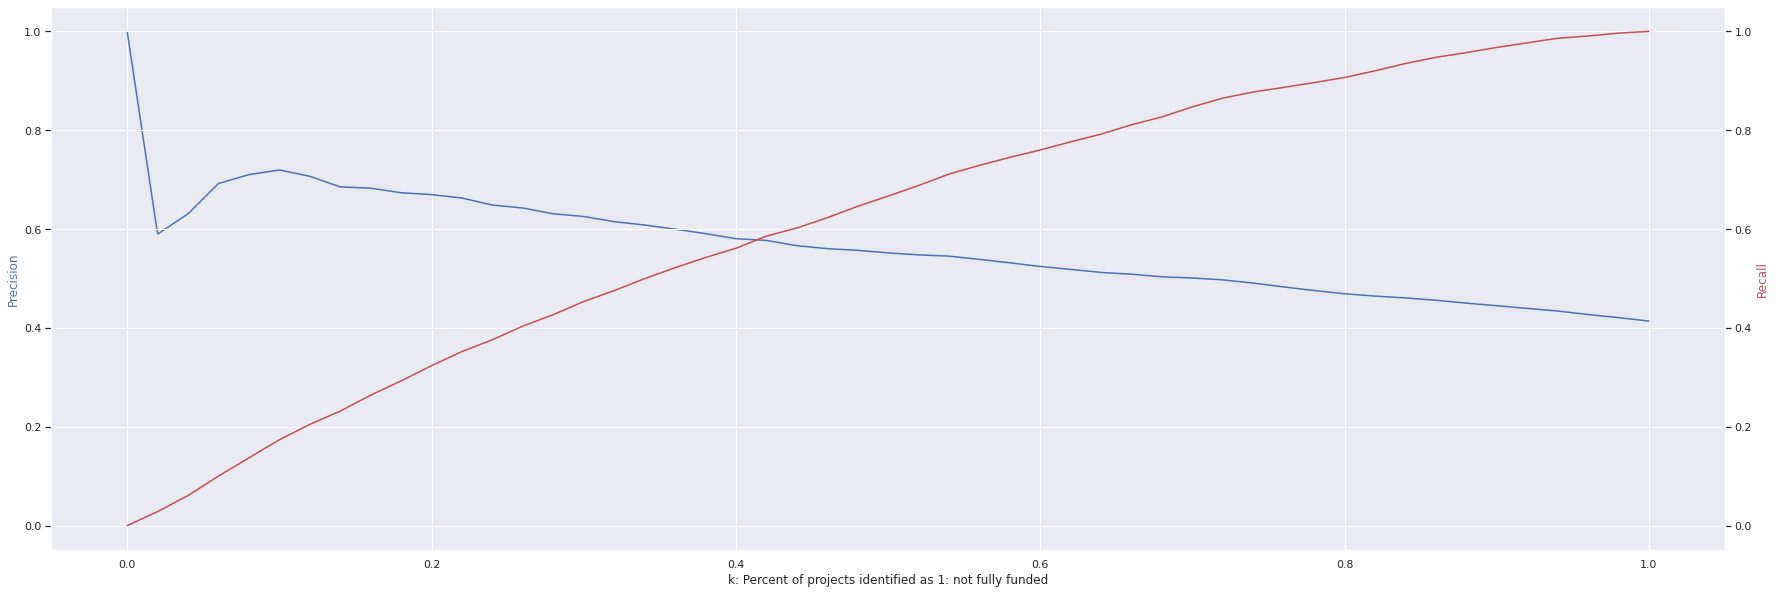

In [82]:
# f, axs = plt.subplots(1,2,figsize=(15,5))
# axs1 = axs[0]
f, axs1 = plt.subplots()
axs2 = axs1.twinx()
axs1.plot(grid, pre_log, 'b', label = 'Precision')
axs2.plot(grid, rec_log, 'r', label = 'Recall')
axs1.set_ylabel('Precision', color = 'b')
axs1.set_ylim(-0.05,1.05)
axs2.set_ylabel('Recall', color = 'r')
axs2.set_ylim(-0.05,1.05)
axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
plt.show()

**Dependencies**

In [ ]:
!pip install sqlalchemy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC

from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

from sklearn import model_selection

from sklearn.metrics import precision_recall_curve, auc, roc_curve

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



**Preprocessing**

In [ ]:
master['date_posted'] = pd.to_datetime(master['date_posted'])
master.fully_funded = master.fully_funded.replace({'f':1, 't':0})
master.head(2)

,Unnamed: 0,projectid,teacher_acctid,schoolid,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,students_reached,date_posted,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,total_donation_amount,avg_msg_num_words,fully_funded,day_of_week_posted,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,IL,suburban,f,Mrs.,f,Special Needs,Other,moderate poverty,Grades 3-5,444.36,7.0,2013-12-31,8.0,33.0,10.0,220.0,1.0,0.0,42.5,30.0,0,1,0.095643,401.86,0.5,0.0
1,1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,ID,urban,f,Mrs.,f,Mathematics,Supplies,high poverty,Grades 3-5,233.24,30.0,2013-12-31,3.0,33.0,14.0,175.0,0.0,0.0,0.0,0.0,1,1,0.000000,233.24,0.5,0.5


 Vectorizing Categorical data

In [ ]:
ohe_school_state = pd.get_dummies(master.school_state)

In [ ]:
ohe_school_metro = pd.get_dummies(master.school_metro)

In [ ]:
ohe_school_charter = pd.get_dummies(master.school_charter)

In [ ]:
ohe_teacher_prefix = pd.get_dummies(master.teacher_prefix)

In [ ]:
ohe_teacher_teach_for_america = pd.get_dummies(master.teacher_teach_for_america)

In [ ]:
ohe_primary_focus_subject = pd.get_dummies(master.primary_focus_subject)

In [ ]:
ohe_resource_type = pd.get_dummies(master.resource_type)

In [ ]:
ohe_poverty_level = pd.get_dummies(master.poverty_level)

In [ ]:
ohe_grade_level = pd.get_dummies(master.grade_level)

In [ ]:
ohe_day_of_week_posted	 = pd.get_dummies(master.day_of_week_posted	)

In [ ]:
num_features = master[['total_price_excluding_optional_support','students_reached','title_num_words','description_num_words','statement_num_words','essay_num_words','num_donors','num_teachers','avg_msg_num_words','percent_fulfilled','amount_remaining','school_pct_funded','teacher_pct_funded']]
labels = master['fully_funded']

In [ ]:
num_features.head(20)

,total_price_excluding_optional_support,students_reached,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,avg_msg_num_words,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,444.36,7.0,8.0,33.0,10.0,220.0,1.0,0.0,30.0,0.095643,401.86,0.500000,0.0000
1,233.24,30.0,3.0,33.0,14.0,175.0,0.0,0.0,0.0,0.000000,233.24,0.500000,0.5000
2,285.09,230.0,3.0,35.0,29.0,390.0,0.0,0.0,0.0,0.000000,285.09,0.500000,0.5000
3,232.94,18.0,3.0,34.0,18.0,187.0,1.0,0.0,0.0,0.182450,190.44,0.541667,0.6000
4,513.41,70.0,3.0,35.0,30.0,347.0,0.0,0.0,0.0,0.000000,513.41,0.000000,0.0000
5,688.11,22.0,6.0,32.0,15.0,187.0,2.0,0.0,24.5,0.061763,645.61,0.000000,0.0000
6,935.16,25.0,2.0,32.0,28.0,396.0,0.0,0.0,0.0,0.000000,935.16,0.625000,0.0000
7,809.32,17.0,2.0,34.0,19.0,443.0,2.0,1.0,9.5,0.876971,99.57,0.000000,0.0000
11,269.90,36.0,3.0,36.0,28.0,192.0,0.0,0.0,0.0,0.000000,269.90,0.000000,0.0000
12,519.03,160.0,5.0,38.0,11.0,194.0,0.0,0.0,0.0,0.000000,519.03,0.000000,0.0000


In [ ]:
num_features.head(20)

,total_price_excluding_optional_support,students_reached,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,avg_msg_num_words,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,444.36,7.0,8.0,33.0,10.0,220.0,1.0,0.0,30.0,0.095643,401.86,0.500000,0.0000
1,233.24,30.0,3.0,33.0,14.0,175.0,0.0,0.0,0.0,0.000000,233.24,0.500000,0.5000
2,285.09,230.0,3.0,35.0,29.0,390.0,0.0,0.0,0.0,0.000000,285.09,0.500000,0.5000
3,232.94,18.0,3.0,34.0,18.0,187.0,1.0,0.0,0.0,0.182450,190.44,0.541667,0.6000
4,513.41,70.0,3.0,35.0,30.0,347.0,0.0,0.0,0.0,0.000000,513.41,0.000000,0.0000
5,688.11,22.0,6.0,32.0,15.0,187.0,2.0,0.0,24.5,0.061763,645.61,0.000000,0.0000
6,935.16,25.0,2.0,32.0,28.0,396.0,0.0,0.0,0.0,0.000000,935.16,0.625000,0.0000
7,809.32,17.0,2.0,34.0,19.0,443.0,2.0,1.0,9.5,0.876971,99.57,0.000000,0.0000
11,269.90,36.0,3.0,36.0,28.0,192.0,0.0,0.0,0.0,0.000000,269.90,0.000000,0.0000
12,519.03,160.0,5.0,38.0,11.0,194.0,0.0,0.0,0.0,0.000000,519.03,0.000000,0.0000


In [ ]:
num_features.describe()

,total_price_excluding_optional_support,students_reached,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,avg_msg_num_words,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
count,5.269940e+05,526878.000000,526979.000000,526905.000000,525702.000000,526991.000000,526994.000000,526994.000000,526994.000000,526695.000000,5.269940e+05,526994.000000,526994.000000
mean,5.480963e+02,99.011124,5.218453,37.537790,19.660384,278.958079,0.737115,0.105312,3.518788,0.059345,5.186635e+02,0.495174,0.287965
std,1.422352e+04,2561.522491,2.310554,9.498199,9.291185,89.632910,2.288948,0.493437,8.271919,0.157459,1.422068e+04,0.420059,0.420944
min,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2.770225e+02,22.000000,3.000000,33.000000,14.000000,212.000000,0.000000,0.000000,0.000000,0.000000,2.500000e+02,0.000000,0.000000
50%,4.174000e+02,30.000000,5.000000,36.000000,19.000000,266.000000,0.000000,0.000000,0.000000,0.000000,3.923350e+02,0.600000,0.000000
75%,5.920000e+02,100.000000,7.000000,42.000000,25.000000,335.000000,1.000000,0.000000,0.000000,0.005029,5.569000e+02,0.920000,0.714286
max,1.025002e+07,999999.000000,49.000000,301.000000,1696.000000,2596.000000,111.000000,45.000000,134.000000,1.000000,1.025002e+07,1.000000,1.000000


In [ ]:
num_features['total_price_excluding_optional_support'] = num_features['total_price_excluding_optional_support'].clip(upper = 2000)
num_features['students_reached'] = num_features['students_reached'].clip(upper = 200)
num_features['statement_num_words'] = num_features['statement_num_words'].clip(upper = 250)
num_features['num_donors'] = num_features['num_donors'].clip(upper = 10)
num_features['num_teachers'] = num_features['num_teachers'].clip(upper = 5)
num_features['avg_msg_num_words'] = num_features['avg_msg_num_words'].clip(upper = 100)
num_features['amount_remaining'] = num_features['amount_remaining'].clip(upper = 2000)

In [ ]:
norm_num_features = (num_features - num_features.min())/(num_features.max() - num_features.min())

In [ ]:
norm_num_features.isna().sum()

total_price_excluding_optional_support       0
students_reached                           116
title_num_words                             15
description_num_words                       89
statement_num_words                       1292
essay_num_words                              3
num_donors                                   0
num_teachers                                 0
avg_msg_num_words                            0
percent_fulfilled                          299
amount_remaining                             0
school_pct_funded                            0
teacher_pct_funded                           0
dtype: int64

In [ ]:
norm_num_features['students_reached'] = norm_num_features['students_reached'].fillna(norm_num_features['students_reached'].mean())
norm_num_features['title_num_words'] = norm_num_features['title_num_words'].fillna(norm_num_features['title_num_words'].mean())
norm_num_features['description_num_words'] = norm_num_features['description_num_words'].fillna(norm_num_features['description_num_words'].mean())
norm_num_features['statement_num_words'] = norm_num_features['statement_num_words'].fillna(norm_num_features['statement_num_words'].mean())
norm_num_features['percent_fulfilled'] = norm_num_features['percent_fulfilled'].fillna(norm_num_features['percent_fulfilled'].mean())
norm_num_features['essay_num_words'] = norm_num_features['essay_num_words'].fillna(norm_num_features['essay_num_words'].mean())


In [ ]:
norm_num_features.isna().sum()

total_price_excluding_optional_support    0
students_reached                          0
title_num_words                           0
description_num_words                     0
statement_num_words                       0
essay_num_words                           0
num_donors                                0
num_teachers                              0
avg_msg_num_words                         0
percent_fulfilled                         0
amount_remaining                          0
school_pct_funded                         0
teacher_pct_funded                        0
dtype: int64

In [ ]:
from scipy.sparse import hstack
features = pd.concat([norm_num_features, ohe_school_state, ohe_school_metro, ohe_school_charter, ohe_teacher_prefix, ohe_teacher_teach_for_america, ohe_primary_focus_subject, ohe_resource_type, ohe_poverty_level,ohe_grade_level, ohe_day_of_week_posted], axis = 1)
features.shape

(526994, 125)

In [ ]:
t_mask = (master['date_posted'] >= '2013-02-01') & (master['date_posted'] <= '2013-07-31')
v_mask = (master['date_posted'] >= '2013-12-01') & (master['date_posted'] <= '2013-12-31')

In [ ]:
x_train, Y_train = features.loc[t_mask], labels.loc[t_mask]
x_test, Y_test = features.loc[v_mask], labels.loc[v_mask]

In [ ]:
def prk(df, k):
  if k == 0.0:
      precision, recall = 1, 0
  else:
      df.sort_values(by=['pred'], ascending = False, inplace = True)
      br = df['fully_funded'].sum() / df.shape[0]
      if k == 1.0:
        precision, recall = br, 1
      else:
        sub = df.head(int(df.shape[0] * k)) # predict these as 1: not fully_funded, or 'f'
        rem = df.tail(df.shape[0] - int(df.shape[0] * k))
        tp = sub['fully_funded'].sum()
        fp = sub.shape[0] - tp
        fn = rem['fully_funded'].sum()
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
  # if k == 0.1:
  #   print('@k={:.2f}, precision={:.3f}, recall={:.3f}'.format(k, precision, recall))
  return precision, recall

**Best SGD Classifier**

[0.01, 0.001]
alpha=0.01, penalty=l1
c=50.00, train_auc_score = 0.77, validation_auc_score = 0.81
precision @ k = 0.1 : 0.821173104434907


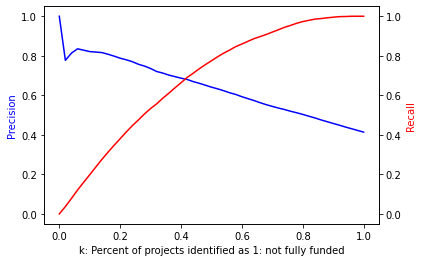

alpha=0.01, penalty=l2
c=50.00, train_auc_score = 0.78, validation_auc_score = 0.81
precision @ k = 0.1 : 0.8340486409155937


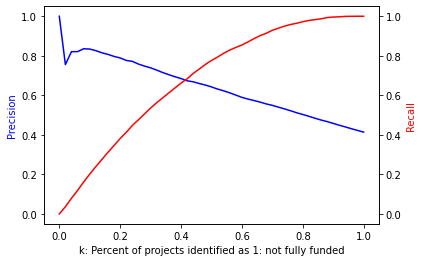

alpha=0.01, penalty=elasticnet
c=50.00, train_auc_score = 0.77, validation_auc_score = 0.81
precision @ k = 0.1 : 0.8340486409155937


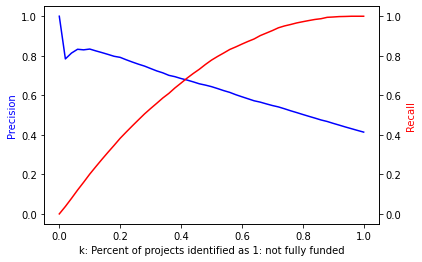

alpha=0.001, penalty=l1
c=50.00, train_auc_score = 0.79, validation_auc_score = 0.82
precision @ k = 0.1 : 0.8168812589413448


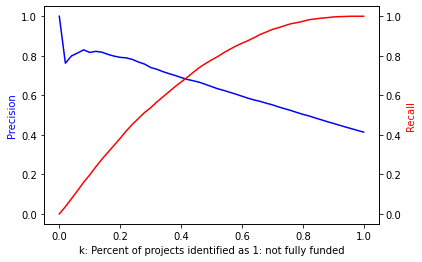

alpha=0.001, penalty=l2
c=50.00, train_auc_score = 0.79, validation_auc_score = 0.81
precision @ k = 0.1 : 0.8168812589413448


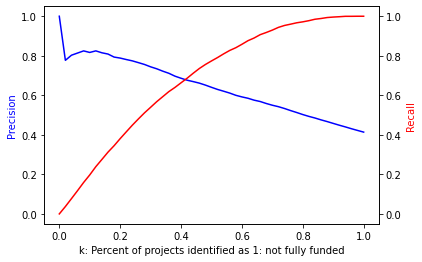

alpha=0.001, penalty=elasticnet
c=50.00, train_auc_score = 0.79, validation_auc_score = 0.81
precision @ k = 0.1 : 0.8154506437768241


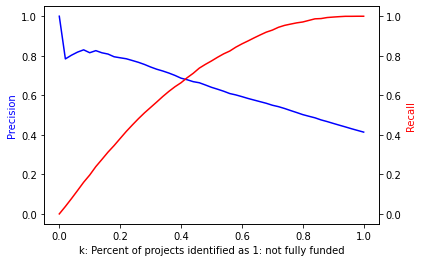

In [ ]:
C = [0.01, 0.001] # hyperparam for SGD classifier.
penalties = ['l1', 'l2', 'elasticnet']
print(C)
from sklearn.metrics import roc_auc_score

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# 
train_auc = []
cv_auc = []

for c in C:
  for p in penalties: 
    print('alpha={}, penalty={}'.format(c,p))
    clf = SGDClassifier(alpha=c, penalty=p, loss='hinge',random_state = 0 ,class_weight = 'balanced')
    clf_s = CalibratedClassifierCV(clf, method='sigmoid')
    clf_s.fit(x_train, Y_train)
    y_train_pred =  clf_s.predict_proba(x_train)[:,1]
    y_test_pred =  clf_s.predict_proba(x_test)[:,1]
    train_auc_score = roc_auc_score(Y_train,y_train_pred)
    train_auc.append((train_auc_score))
    cv_auc.append(roc_auc_score(Y_test, y_test_pred))
    print('c={:.2f}, train_auc_score = {:.2f}, validation_auc_score = {:.2f}'.format(i,train_auc_score,roc_auc_score(Y_test, y_test_pred)))
    y_score = pd.Series(y_test_pred)
    Y_test_np = Y_test.to_numpy()
    Y_test_pd = pd.Series(Y_test_np)
    combo = pd.concat([Y_test_pd, y_score], axis=1)
    combo.columns = ['fully_funded', 'pred']

    grid = np.arange(0,1.02,0.02)
    pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
    for i, k in enumerate(grid):
      pre_log[i], rec_log[i] = prk(combo, k)
      if k == 0.1:
        print('precision @ k = 0.1 : {}'.format(pre_log[i]))

    # f, axs = plt.subplots(1,2,figsize=(15,5))
    # axs1 = axs[0]
    f, axs1 = plt.subplots()
    axs2 = axs1.twinx()
    axs1.plot(grid, pre_log, 'b', label = 'Precision')
    axs2.plot(grid, rec_log, 'r', label = 'Recall')
    axs1.set_ylabel('Precision', color = 'b')
    axs1.set_ylim(-0.05,1.05)
    axs2.set_ylabel('Recall', color = 'r')
    axs2.set_ylim(-0.05,1.05)
    axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
    plt.show()

**Best RandomForest**

c=50.00000, train_auc_score = 1.00, validation_auc_score = 0.82
precision @ k = 0.8168812589413448


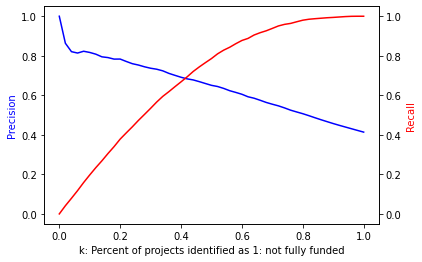

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# 
train_auc = []
cv_auc = []

clf_rf = RandomForestClassifier(n_estimators = 500, min_samples_split=5, random_state=0)
clf_rf.fit(x_train, Y_train)
y_train_pred =  clf_rf.predict_proba(x_train)[:,1]
y_test_pred =  clf_rf.predict_proba(x_test)[:,1]
train_auc_score = roc_auc_score(Y_train,y_train_pred)
train_auc.append((train_auc_score))
cv_auc.append(roc_auc_score(Y_test, y_test_pred))
print('c={:.5f}, train_auc_score = {:.2f}, validation_auc_score = {:.2f}'.format(i,train_auc_score,roc_auc_score(Y_test, y_test_pred)))

y_score = pd.Series(y_test_pred)
Y_test_np = Y_test.to_numpy()
Y_test_pd = pd.Series(Y_test_np)
combo = pd.concat([Y_test_pd, y_score], axis=1)
combo.columns = ['fully_funded', 'pred']

grid = np.arange(0,1.02,0.02)
pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
for i, k in enumerate(grid):
  pre_log[i], rec_log[i] = prk(combo, k)
  if k == 0.1:
    print('precision @ k = {}'.format(pre_log[i]))

# f, axs = plt.subplots(1,2,figsize=(15,5))
# axs1 = axs[0]
f, axs1 = plt.subplots()
axs2 = axs1.twinx()
axs1.plot(grid, pre_log, 'b', label = 'Precision')
axs2.plot(grid, rec_log, 'r', label = 'Recall')
axs1.set_ylabel('Precision', color = 'b')
axs1.set_ylim(-0.05,1.05)
axs2.set_ylabel('Recall', color = 'r')
axs2.set_ylim(-0.05,1.05)
axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
plt.show()

**best rf 2**

c=50.00000, train_auc_score = 0.99, validation_auc_score = 0.82
precision @ k = 0.8140200286123033


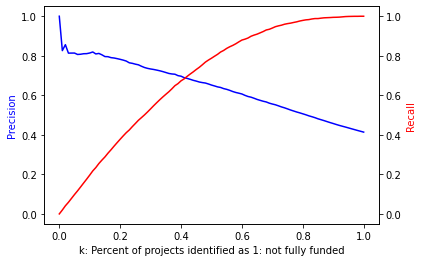

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# 
train_auc = []
cv_auc = []

clf_rf = RandomForestClassifier(n_estimators = 1000, min_samples_split=10, random_state=0)
clf_rf.fit(x_train, Y_train)
y_train_pred =  clf_rf.predict_proba(x_train)[:,1]
y_test_pred =  clf_rf.predict_proba(x_test)[:,1]
train_auc_score = roc_auc_score(Y_train,y_train_pred)
train_auc.append((train_auc_score))
cv_auc.append(roc_auc_score(Y_test, y_test_pred))
print('c={:.5f}, train_auc_score = {:.2f}, validation_auc_score = {:.2f}'.format(i,train_auc_score,roc_auc_score(Y_test, y_test_pred)))

y_score = pd.Series(y_test_pred)
Y_test_np = Y_test.to_numpy()
Y_test_pd = pd.Series(Y_test_np)
combo = pd.concat([Y_test_pd, y_score], axis=1)
combo.columns = ['fully_funded', 'pred']

grid = np.arange(0,1.01,0.01)
pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
for i, k in enumerate(grid):
  pre_log[i], rec_log[i] = prk(combo, k)
  if k == 0.1:
    print('precision @ k = {}'.format(pre_log[i]))

# f, axs = plt.subplots(1,2,figsize=(15,5))
# axs1 = axs[0]
f, axs1 = plt.subplots()
axs2 = axs1.twinx()
axs1.plot(grid, pre_log, 'b', label = 'Precision')
axs2.plot(grid, rec_log, 'r', label = 'Recall')
axs1.set_ylabel('Precision', color = 'b')
axs1.set_ylim(-0.05,1.05)
axs2.set_ylabel('Recall', color = 'r')
axs2.set_ylim(-0.05,1.05)
axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
plt.show()

**best RF3**

c=100.00000, train_auc_score = 0.95, validation_auc_score = 0.82
precision @ k = 0.8140200286123033


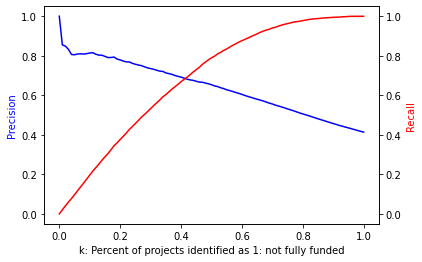

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# 
train_auc = []
cv_auc = []

clf_rf = RandomForestClassifier(n_estimators = 1000, min_samples_split=25, random_state=0)
clf_rf.fit(x_train, Y_train)
y_train_pred =  clf_rf.predict_proba(x_train)[:,1]
y_test_pred =  clf_rf.predict_proba(x_test)[:,1]
train_auc_score = roc_auc_score(Y_train,y_train_pred)
train_auc.append((train_auc_score))
cv_auc.append(roc_auc_score(Y_test, y_test_pred))
print('c={:.5f}, train_auc_score = {:.2f}, validation_auc_score = {:.2f}'.format(i,train_auc_score,roc_auc_score(Y_test, y_test_pred)))

y_score = pd.Series(y_test_pred)
Y_test_np = Y_test.to_numpy()
Y_test_pd = pd.Series(Y_test_np)
combo = pd.concat([Y_test_pd, y_score], axis=1)
combo.columns = ['fully_funded', 'pred']

grid = np.arange(0,1.01,0.01)
pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
for i, k in enumerate(grid):
  pre_log[i], rec_log[i] = prk(combo, k)
  if k == 0.1:
    print('precision @ k = {}'.format(pre_log[i]))

# f, axs = plt.subplots(1,2,figsize=(15,5))
# axs1 = axs[0]
f, axs1 = plt.subplots()
axs2 = axs1.twinx()
axs1.plot(grid, pre_log, 'b', label = 'Precision')
axs2.plot(grid, rec_log, 'r', label = 'Recall')
axs1.set_ylabel('Precision', color = 'b')
axs1.set_ylim(-0.05,1.05)
axs2.set_ylabel('Recall', color = 'r')
axs2.set_ylim(-0.05,1.05)
axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
plt.show()

In [ ]:
import pickle
pkl_filename = "n_estimators_10000-min_samples_split_10.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_rf, file)

In [ ]:
# sample code for model load and testing
# # Load from file
# with open(pkl_filename, 'rb') as file:
#     pickle_model = pickle.load(file)

**best DT**

In [ ]:
criterions =  ['gini','entropy']
min_samples_splits = [2, 5, 10]

In [ ]:
# Criterion: [“gini”, “entropy”]; max_depth:[5, 10, None]; min_samples_split:[2, 5, 10]
import sklearn.tree as tree
def runDT(x_train, Y_train, x_test, Y_test, criterion='gini', min_samples_split = 2):
  clf_s = tree.DecisionTreeClassifier(criterion=criterion, min_samples_split=min_samples_split)
  clf_s.fit(x_train, Y_train)
  y_train_pred =  clf_s.predict_proba(x_train)[:,1]
  y_test_pred =  clf_s.predict_proba(x_test)[:,1]

  y_score = y_test_pred
  y_score = pd.Series(y_test_pred)

  Y_test_np = Y_test.to_numpy()
  Y_test_pd = pd.Series(Y_test_np)
  combo = pd.concat([Y_test_pd, y_score], axis=1)
  combo.columns = ['fully_funded', 'pred']
  prec = prk(combo, 0.1)

  return prec

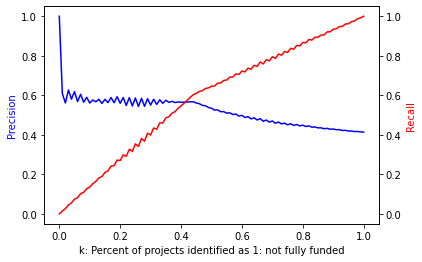

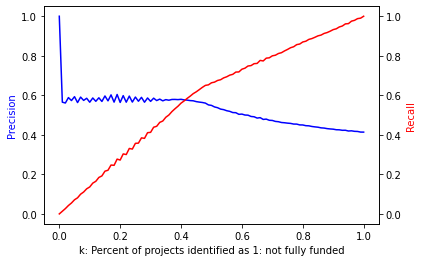

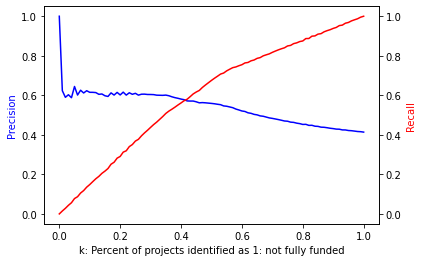

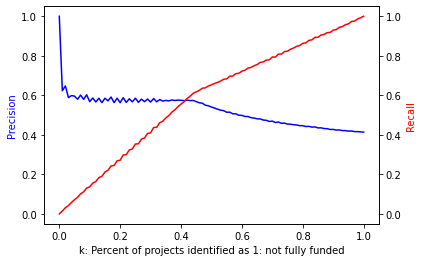

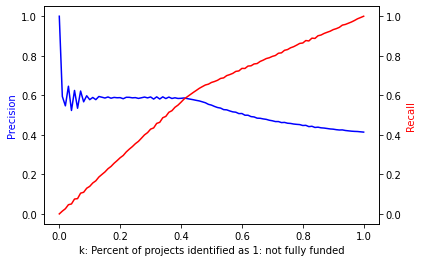

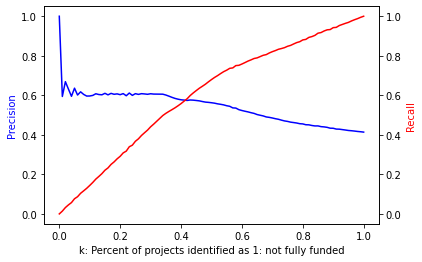

In [ ]:
for criterion in criterions:
  for min_samples_split in min_samples_splits:
    clf_s = tree.DecisionTreeClassifier(criterion=criterion, min_samples_split=min_samples_split)
    clf_s.fit(x_train, Y_train)
    y_train_pred =  clf_s.predict_proba(x_train)[:,1]
    y_test_pred =  clf_s.predict_proba(x_test)[:,1]
    train_auc_score = roc_auc_score(Y_train,y_train_pred)
    train_auc.append((train_auc_score))
    cv_auc.append(roc_auc_score(Y_test, y_test_pred))
    y_score = pd.Series(y_test_pred)
    Y_test_np = Y_test.to_numpy()
    Y_test_pd = pd.Series(Y_test_np)
    combo = pd.concat([Y_test_pd, y_score], axis=1)
    combo.columns = ['fully_funded', 'pred']
    grid = np.arange(0,1.01,0.01)
    pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
    for i, k in enumerate(grid):
      pre_log[i], rec_log[i] = prk(combo, k)

    # f, axs = plt.subplots(1,2,figsize=(15,5))
    # axs1 = axs[0]
    f, axs1 = plt.subplots()
    axs2 = axs1.twinx()
    axs1.plot(grid, pre_log, 'b', label = 'Precision')
    axs2.plot(grid, rec_log, 'r', label = 'Recall')
    axs1.set_ylabel('Precision', color = 'b')
    axs1.set_ylim(-0.05,1.05)
    axs2.set_ylabel('Recall', color = 'r')
    axs2.set_ylim(-0.05,1.05)
    axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
    plt.show()


**end of pr-k**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

def runRF(x_train, Y_train, x_test, Y_test, n_estimators=1000, min_samples_split=2):
  train_auc = []
  cv_auc = []

  clf_rf = RandomForestClassifier(n_estimators = n_estimators, min_samples_split=min_samples_split, random_state=0)
  clf_rf.fit(x_train, Y_train)
  y_train_pred =  clf_rf.predict_proba(x_train)[:,1]
  y_test_pred =  clf_rf.predict_proba(x_test)[:,1]
  train_auc_score = roc_auc_score(Y_train,y_train_pred)
  train_auc.append((train_auc_score))
  cv_auc.append(roc_auc_score(Y_test, y_test_pred))
  y_score = y_test_pred
  y_score = pd.Series(y_test_pred)

  Y_test_np = Y_test.to_numpy()
  Y_test_pd = pd.Series(Y_test_np)
  combo = pd.concat([Y_test_pd, y_score], axis=1)
  combo.columns = ['fully_funded', 'pred']
  prec = prk(combo, 0.1)

  return prec
  

In [ ]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

def dateShift(given_date, n):
  date_format = '%Y-%m-%d'
  dtObj = datetime.strptime(given_date, date_format)
  new_date = dtObj - relativedelta(months=n)
  return str(new_date.date())
  


In [ ]:
from sklearn.metrics import precision_recall_curve

threshold = '2009-12-01'
t_start, t_end = '2013-02-01', '2013-07-31'
v_start, v_end = '2013-12-01', '2013-12-31'
prec_expandedRF_log = []
date_log, base_log = [], []



while t_start > threshold:
  print('t_start = {}, t_end = {}, v_start = {}, v_end = {}'.format(t_start, t_end, v_start, v_end))
  t_mask = (master['date_posted'] >= t_start) & (master['date_posted'] <= t_end)
  v_mask = (master['date_posted'] >= v_start) & (master['date_posted'] <= v_end)
  
  x_train, Y_train = features.loc[t_mask], labels.loc[t_mask]
  x_test, Y_test = features.loc[v_mask], labels.loc[v_mask]
  # tmp = run_baseline1(master.loc[v_mask], 0.1)
  # base_prec= tmp[0]
  # base_log.append(base_prec)
  # date_log.append(v_start)

  n_estimatorss = [500, 1000]
  min_samples_splits = [5, 25]
  for n_estimators in n_estimatorss:
    for min_samples_split in min_samples_splits:
      prec= runRF(x_train, Y_train, x_test, Y_test, n_estimators=n_estimators, min_samples_split = min_samples_split)
      prec = prec[0]
      prec_expandedRF_log.append(prec)
      print('n_estimators={}, min_samples_split={}, precision @ 10: {}'.format(n_estimators, min_samples_split, prec))
  
  t_start, t_end = dateShift(t_start, 3), dateShift(t_end, 3)
  v_start, v_end = dateShift(v_start, 3), dateShift(v_end, 3)
  

t_start = 2013-02-01, t_end = 2013-07-31, v_start = 2013-12-01, v_end = 2013-12-31
n_estimators=500, min_samples_split=5, precision @ 10: 0.8168812589413448
n_estimators=500, min_samples_split=25, precision @ 10: 0.8154506437768241
n_estimators=1000, min_samples_split=5, precision @ 10: 0.8197424892703863
n_estimators=1000, min_samples_split=25, precision @ 10: 0.8140200286123033
t_start = 2012-11-01, t_end = 2013-04-30, v_start = 2013-09-01, v_end = 2013-09-30
n_estimators=500, min_samples_split=5, precision @ 10: 0.3887545344619105
n_estimators=500, min_samples_split=25, precision @ 10: 0.39238210399032647
n_estimators=1000, min_samples_split=5, precision @ 10: 0.38331318016928656
n_estimators=1000, min_samples_split=25, precision @ 10: 0.39721886336154777
t_start = 2012-08-01, t_end = 2013-01-30, v_start = 2013-06-01, v_end = 2013-06-30
n_estimators=500, min_samples_split=5, precision @ 10: 0.7933579335793358
n_estimators=500, min_samples_split=25, precision @ 10: 0.7841328413284133

In [61]:
with open('ref.txt') as f:
    lines = f.readlines()

['t_start = 2013-02-01, t_end = 2013-07-31, v_start = 2013-12-01, v_end = 2013-12-31\n', 'n_estimators=500, min_samples_split=5, precision @ 10: 0.8168812589413448\n', 'n_estimators=500, min_samples_split=25, precision @ 10: 0.8154506437768241\n', 'n_estimators=1000, min_samples_split=5, precision @ 10: 0.8197424892703863\n', 'n_estimators=1000, min_samples_split=25, precision @ 10: 0.8140200286123033\n', 't_start = 2012-11-01, t_end = 2013-04-30, v_start = 2013-09-01, v_end = 2013-09-30\n', 'n_estimators=500, min_samples_split=5, precision @ 10: 0.3887545344619105\n', 'n_estimators=500, min_samples_split=25, precision @ 10: 0.39238210399032647\n', 'n_estimators=1000, min_samples_split=5, precision @ 10: 0.38331318016928656\n', 'n_estimators=1000, min_samples_split=25, precision @ 10: 0.39721886336154777\n', 't_start = 2012-08-01, t_end = 2013-01-30, v_start = 2013-06-01, v_end = 2013-06-30\n', 'n_estimators=500, min_samples_split=5, precision @ 10: 0.7933579335793358\n', 'n_estimators

In [64]:
for line in lines:
  if '@' in line:
    prec_expandedRF_log.append(float(line[line.index('@') + 6:]))

In [92]:
from sklearn.metrics import precision_recall_curve

threshold = '2009-12-01'
t_start, t_end = '2013-02-01', '2013-07-31'
v_start, v_end = '2013-12-01', '2013-12-31'
date_log, base_log = [], []



while t_start > threshold:
  print('t_start = {}, t_end = {}, v_start = {}, v_end = {}'.format(t_start, t_end, v_start, v_end))
  t_mask = (master['date_posted'] >= t_start) & (master['date_posted'] <= t_end)
  v_mask = (master['date_posted'] >= v_start) & (master['date_posted'] <= v_end)
  
  x_train, Y_train = features.loc[t_mask], labels.loc[t_mask]
  x_test, Y_test = features.loc[v_mask], labels.loc[v_mask]
  tmp = run_baseline1(master.loc[v_mask], 0.1)
  base_prec= tmp[0]
  base_log.append(base_prec)
  date_log.append(v_start)

  # n_estimatorss = [500, 1000]
  # min_samples_splits = [5, 25]
  # for n_estimators in n_estimatorss:
  #   for min_samples_split in min_samples_splits:
  #     prec= runRF(x_train, Y_train, x_test, Y_test, n_estimators=n_estimators, min_samples_split = min_samples_split)
  #     prec = prec[0]
  #     prec_expandedRF_log.append(prec)
  #     print('n_estimators={}, min_samples_split={}, precision @ 10: {}'.format(n_estimators, min_samples_split, prec))
  
  t_start, t_end = dateShift(t_start, 3), dateShift(t_end, 3)
  v_start, v_end = dateShift(v_start, 3), dateShift(v_end, 3)
  

t_start = 2013-02-01, t_end = 2013-07-31, v_start = 2013-12-01, v_end = 2013-12-31
@k=0.10, precision=0.720, recall=0.174
t_start = 2012-11-01, t_end = 2013-04-30, v_start = 2013-09-01, v_end = 2013-09-30
@k=0.10, precision=0.269, recall=0.102
t_start = 2012-08-01, t_end = 2013-01-30, v_start = 2013-06-01, v_end = 2013-06-30
@k=0.10, precision=0.672, recall=0.150
t_start = 2012-05-01, t_end = 2012-10-30, v_start = 2013-03-01, v_end = 2013-03-30
@k=0.10, precision=0.534, recall=0.136
t_start = 2012-02-01, t_end = 2012-07-30, v_start = 2012-12-01, v_end = 2012-12-30
@k=0.10, precision=0.506, recall=0.137
t_start = 2011-11-01, t_end = 2012-04-30, v_start = 2012-09-01, v_end = 2012-09-30
@k=0.10, precision=0.314, recall=0.120
t_start = 2011-08-01, t_end = 2012-01-30, v_start = 2012-06-01, v_end = 2012-06-30
@k=0.10, precision=0.510, recall=0.149
t_start = 2011-05-01, t_end = 2011-10-30, v_start = 2012-03-01, v_end = 2012-03-30
@k=0.10, precision=0.443, recall=0.130
t_start = 2011-02-01, t_

In [88]:
master = pd.read_csv('processed_mastersheet1025.zip')
master = master.drop(master[master.percent_fulfilled >= 1.0].index)
from sklearn.metrics import precision_recall_curve
from dateutil.relativedelta import relativedelta
from datetime import datetime

def dateShift(given_date, n):
  date_format = '%Y-%m-%d'
  dtObj = datetime.strptime(given_date, date_format)
  new_date = dtObj - relativedelta(months=n)
  return str(new_date.date())

threshold = '2009-12-01'
t_start, t_end = '2013-02-01', '2013-07-31'
v_start, v_end = '2013-12-01', '2013-12-31'
base_rate = []

while t_start > threshold:
  # print('t_start = {}, t_end = {}, v_start = {}, v_end = {}'.format(t_start, t_end, v_start, v_end))
  t_mask = (master['date_posted'] >= t_start) & (master['date_posted'] <= t_end)
  v_mask = (master['date_posted'] >= v_start) & (master['date_posted'] <= v_end)
  
  tmp = run_baseline1(master.loc[v_mask], 1)
  base_rate.append(tmp[0])
  base_prec = run_baseline1(master.loc[v_mask], 0.1)[0]


  print('base_rate: {}'.format(tmp[0]), 'baseline : {}'.format(base_prec))

  
  
  t_start, t_end = dateShift(t_start, 3), dateShift(t_end, 3)
  v_start, v_end = dateShift(v_start, 3), dateShift(v_end, 3)
base_rate = np.array(base_rate)

@k=0.10, precision=0.720, recall=0.174
base_rate: 0.4138325235781652 baseline : 0.7195994277539342
@k=0.10, precision=0.269, recall=0.102
base_rate: 0.26434141328658645 baseline : 0.26904474002418377
@k=0.10, precision=0.672, recall=0.150
base_rate: 0.4481741054961269 baseline : 0.6715867158671587
@k=0.10, precision=0.534, recall=0.136
base_rate: 0.3926279112415184 baseline : 0.5339449541284403
@k=0.10, precision=0.506, recall=0.137
base_rate: 0.3698334361505244 baseline : 0.5061728395061729
@k=0.10, precision=0.314, recall=0.120
base_rate: 0.26200773958570456 baseline : 0.31359149582384205
@k=0.10, precision=0.510, recall=0.149
base_rate: 0.34144645340751045 baseline : 0.5104408352668214
@k=0.10, precision=0.443, recall=0.130
base_rate: 0.33952557873678196 baseline : 0.4434907010014306
@k=0.10, precision=0.491, recall=0.194
base_rate: 0.2528803895949638 baseline : 0.49108204518430437
@k=0.10, precision=0.378, recall=0.134
base_rate: 0.2827586206896552 baseline : 0.3779608650875386
@k=

In [66]:
# iter for RandomForest result
iter_expandedRF = np.arange(len(date_log))
iter_expandedRF = iter_expandedRF * len(n_estimatorss) * len(min_samples_splits)
prec_expandedRF_log_np = np.array(prec_expandedRF_log)

In [76]:
import pickle
with open("cohort_corrected_more_features_expandedRF.txt", "wb") as fp:
  pickle.dump([date_log, 0, prec_expandedRF_log_np], fp)

**Plotting**

In [49]:
# import pickle
# with open('cohort_correted_LinearSVM_RF.txt','rb') as f:
#   backbone_date_log, backbone_base_log, backbone_prec_log_np, backbone_prec_RF_log_np = pickle.load(f)

In [89]:
backbone_data_log = date_log
backbone_base_log = base_log

In [79]:
# alphas = [0.0001, 0.001, 0.01, 0.1, 0.5]
# penalties = ['l2', 'l1', 'elasticnet']

n_estimatorss = [500, 1000]
min_samples_splits = [5, 25]

# exp_n_estimatorss = [10000]
# exp_max_depths = [2, 10]

# criterions =  ['gini','entropy']
# max_depths = [5, 10, None]
# DT_min_samples_splits = [2, 5, 10]

# # iter for LinearSVM result
# iter = np.arange(len(backbone_date_log))
# iter = iter * len(alphas) * len(penalties)
# # prec_log_np = np.array(backbone_prec_log)


# # iter for RandomForest result
# iter_RF = np.arange(len(backbone_date_log))
# iter_RF = iter_RF * len(n_estimatorss) * len(min_samples_splits)
# backbone_prec_expanded_RF_log_np = np.array(backbone_prec_expanded_RF_log)

# # iter for expandedRandomForest result
# iter_expanded_RF = np.arange(len(backbone_date_log))
# iter_expanded_RF = iter_expanded_RF * len(exp_n_estimatorss) * len(exp_max_depths)
# # backbone_prec_expanded_RF_log

# # iter for DecisionTree result
# iter_DT = np.arange(len(backbone_date_log))
# iter_DT = iter_DT * len(criterions) * len(max_depths) * len(DT_min_samples_splits)


**Plot original**

**Grouped color**

[(0.0, 1.0)]

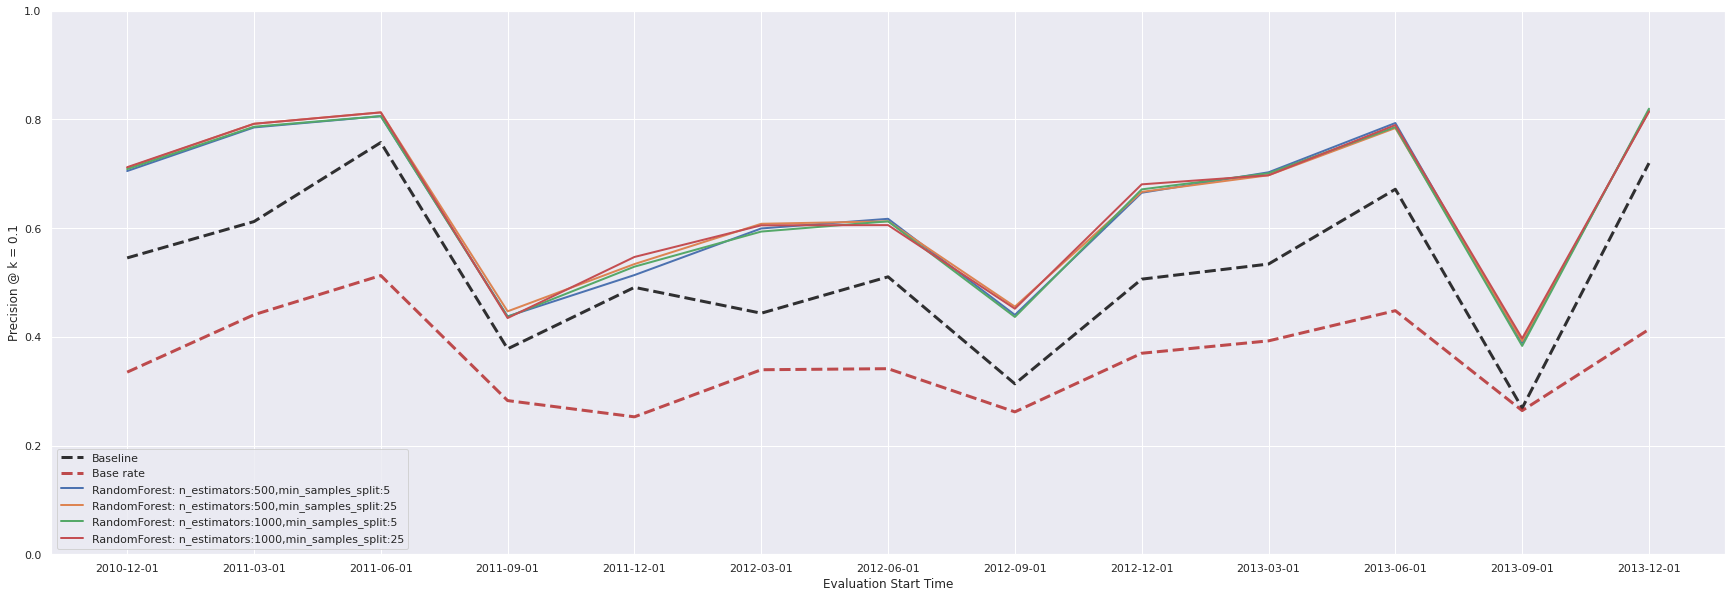

In [91]:
import seaborn as sns
sns.set(rc={'figure.figsize':(30,10)})
fig = sns.lineplot(x = backbone_date_log[::-1], y = backbone_base_log[::-1],linewidth = 3, alpha = 0.8, color = 'black')
sns.lineplot(x = backbone_date_log[::-1], y = base_rate[::-1], linewidth = 3, alpha = 0.8, color = 'firebrick')
# for i in range(len(alphas)*len(penalties)):
#   iter_current = iter + i
#   # print(i, iter)
#   prec_log_ind = backbone_prec_log_np[iter_current]
#   sns.lineplot(x = backbone_date_log[::-1], y = prec_log_ind[::-1],color='mediumpurple', linewidth = 2)

for i in range(len(n_estimatorss)*len(min_samples_splits)):
  iter_current = iter_expandedRF + i
  # print(i, iter)
  prec_RF_log_ind = prec_expandedRF_log_np[iter_current]
  sns.lineplot(x = backbone_date_log[::-1], y = prec_RF_log_ind[::-1], linewidth = 2)

# for i in range(len(exp_n_estimatorss)*len(exp_max_depths)):
#   iter_current = iter_expanded_RF + i
#   # print(i, iter)
#   prec_expanded_RF_log_ind = prec_expanded_RF_log_np[iter_current]
#   sns.lineplot(x = backbone_date_log[::-1], y = prec_expanded_RF_log_ind[::-1],color = 'tan', linewidth = 2)

# for i in range(len(criterions)*len(max_depths)*len(DT_min_samples_splits)):
#   iter_current = iter_DT + i
#   # print(i, iter)
#   prec_DT_log_ind = prec_DT_log_np[iter_current]
#   sns.lineplot(x = backbone_date_log[::-1], y = prec_DT_log_ind[::-1], color = 'lightblue', linewidth = 2)

fig.lines[0].set_linestyle("--")
fig.lines[1].set_linestyle("--")

legends = []
# for i, alpha in enumerate(alphas):
#   for j, penalty in enumerate(penalties):
#     legends.append('linearSVM: alpha:{},penalty:{}'.format(alpha,penalty))

for i, n in enumerate(n_estimatorss):
  for j, m in enumerate(min_samples_splits):
    legends.append('RandomForest: n_estimators:{},min_samples_split:{}'.format(n, m))

# for i, n in enumerate(exp_n_estimatorss):
#   for j, m in enumerate(exp_max_depths):
#     legends.append('RandomForest: n_estimators:{},max_depth:{}'.format(n, m))

# for i, n in enumerate(criterions):
#   for j, m in enumerate(max_depths):
#     for k, l in enumerate(DT_min_samples_splits):
#       legends.append('DecisionTree: criterion:{},max_depth:{},min_samples_split:{}'.format(n, m,l))



legends = ['Baseline', 'Base rate'] + legends
plt.legend(labels=legends)
fig.set(xlabel = 'Evaluation Start Time', ylabel = 'Precision @ k = 0.1')
fig.set(ylim=(0, 1))